#**CONTENTS**
1. Importing Libraries
2. Defining Image Paths
3. Exploring Dataset
4. Data Augmentation and Visualization
5. Defining the Model
6. Prediction

##**1. Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import pathlib

##**2. Defining Image Paths**

In [2]:
#For Training data
train_dir = "/content/drive/MyDrive/Damage Classifier/training/"
#For Validation data
validation_dir = "/content/drive/MyDrive/Damage Classifier/validation"

#For Training -> Damage data
train_damage_dir = "/content/drive/MyDrive/Damage Classifier/training/00-damage"
#For Training -> Whole data
train_whole_dir = "/content/drive/MyDrive/Damage Classifier/training/01-whole"

#For Validation -> Damage data
validation_damage_dir = "/content/drive/MyDrive/Damage Classifier/validation/00-damage"
#For Validation -> Whole data
validation_whole_dir = "/content/drive/MyDrive/Damage Classifier/validation/01-whole"

##**3. Exploring Dataset**

In [3]:
root=pathlib.Path(train_dir)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print("The classes present in the dataset are: ",classes)

The classes present in the dataset are:  ['00-damage', '01-whole']


##**4. Data Augmentation and Visualization**

Techniques used for Data Augmentation:
* Horizintal Flip


Techniques used for Image Tranformation:
* Resize the images to 150x150
* Changing image's numpy array to tensors
* Normalization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

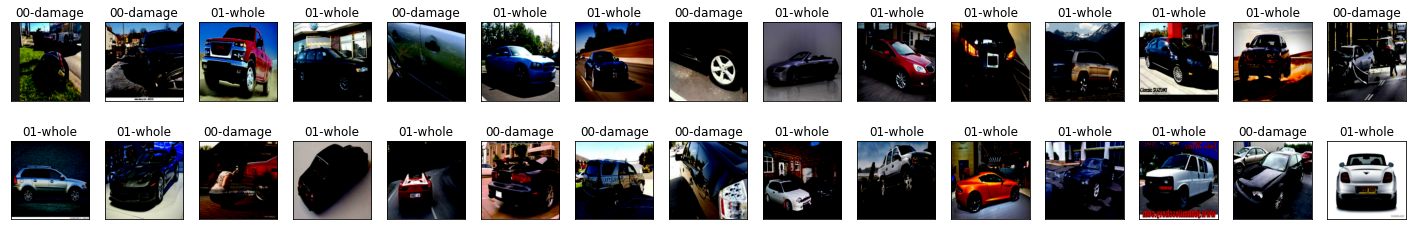

In [4]:
#Data Augmentation
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])


#defining batch size of images
batch_size = 30

#Loading Images from train dataset
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_dir,transform=transformer),
    batch_size=batch_size, shuffle=True
)

#Loading Images from validation dataset
validation_loader=DataLoader(
    torchvision.datasets.ImageFolder(validation_dir,transform=transformer),
    batch_size=batch_size, shuffle=True
)

#Generating batch of images 
dataiter = iter(train_loader)
images, labels = dataiter.next()

#Plotting the images and their corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].permute(1,2,0), cmap='gray')
    ax.set_title(classes[labels[idx]])

##**5. Defining the Model**


In [5]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout, Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

# using CNN 
model = Sequential()

# Convolutional layer and maxpool layer 1
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(MaxPool2D(2,2))

# Convolutional layer and maxpool layer 2
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))

# Convolutional layer and maxpool layer 3
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))

# Convolutional layer and maxpool layer 4
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))

# This layer flattens the resulting image array to 1D array
model.add(keras.layers.Flatten())

# Hidden layer and Rectified Linear Unit activation function 
model.add(Dense(512,activation='relu'))

# Output layer with single neuron
# Using sigmoid so as our model output is between 0 and 1
# with 0 - damage car & 1 - not damage car
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [16]:
from keras import backend as K


def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))
    
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[precision, recall, accuracy])

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1, min_delta=0.001)
modelcheck = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

In [14]:
train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory(train_dir,
                                          target_size=(150,150),
                                          batch_size = 32,
                                          class_mode = 'binary')
                                         
validation_dataset = test.flow_from_directory(validation_dir,
                                          target_size=(150,150),
                                          batch_size =32,
                                          class_mode = 'binary')



Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [17]:
history = model.fit(train_dataset, 
                    validation_data=validation_dataset,
                    epochs=20,
                    callbacks=[earlystop,modelcheck],
                    batch_size=32)

Epoch 1/20
58/58 [==============================] - ETA: 0s - loss: 0.6981 - precision: 0.4992 - recall: 0.7054 - accuracy: 0.5501
Epoch 1: val_accuracy improved from -inf to 0.59653, saving model to best_model.hdf5
58/58 [==============================] - 133s 2s/step - loss: 0.6981 - precision: 0.4992 - recall: 0.7054 - accuracy: 0.5501 - val_loss: 0.6738 - val_precision: 0.7781 - val_recall: 0.2627 - val_accuracy: 0.5965
Epoch 2/20
58/58 [==============================] - ETA: 0s - loss: 0.6494 - precision: 0.7106 - recall: 0.5712 - accuracy: 0.6433
Epoch 2: val_accuracy improved from 0.59653 to 0.69028, saving model to best_model.hdf5
58/58 [==============================] - 18s 319ms/step - loss: 0.6494 - precision: 0.7106 - recall: 0.5712 - accuracy: 0.6433 - val_loss: 0.6110 - val_precision: 0.6617 - val_recall: 0.8061 - val_accuracy: 0.6903
Epoch 3/20
58/58 [==============================] - ETA: 0s - loss: 0.5869 - precision: 0.7083 - recall: 0.6595 - accuracy: 0.6886
Epoch 3:

##**6. Prediction**

[[0.]]


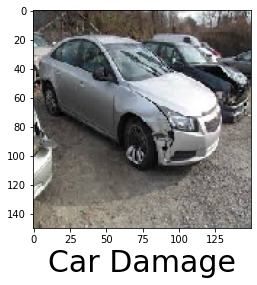

In [18]:
from tensorflow.keras.preprocessing import image

# Our predict function
def predictImage(filename):
    
    img = image.load_img(filename,target_size=(150,150))
    plt.imshow(img)
    
    Y = image.img_to_array(img)
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val < 0.5:
        plt.xlabel("Car Damage",fontsize=30)
    elif val >= 0.5:
        plt.xlabel("Car Not Damage",fontsize=30)

predictImage("/content/drive/MyDrive/Damage Classifier/validation/00-damage/0077.JPEG")

[[1.]]


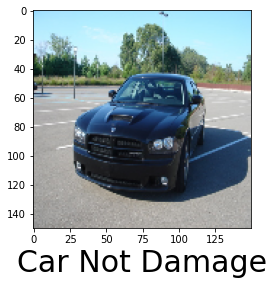

In [19]:
from tensorflow.keras.preprocessing import image

# Our predict function
def predictImage(filename):
    
    img = image.load_img(filename,target_size=(150,150))
    plt.imshow(img)
    
    Y = image.img_to_array(img)
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val < 0.5:
        plt.xlabel("Car Damage",fontsize=30)
    elif val >= 0.5:
        plt.xlabel("Car Not Damage",fontsize=30)

predictImage("/content/drive/MyDrive/Damage Classifier/validation/01-whole/0099.jpg")